# Project : Credit Card Fraud Detection 

## Problem Statement
Credit card fraud results in significant financial losses each year. Detecting fraudulent transactions early is critical to prevent loss for both consumers and businesses.
The challenge is that fraudulent transactions are extremely rare compared to legitimate transactions (highly imbalanced dataset).


## Solution 

Build a Machine Learning model that detects fraudulent transactions with high accuracy, while minimizing false positives.

## Goals
Predict if a transaction is fraudulent based on anonymized features (from PCA), Time, and Amount.

Handle class imbalance effectively to improve recall (catching fraud) without inflating false positives.

Evaluate model performance using appropriate metrics (not just accuracy).

### Data
- source : Kaggle : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?select=creditcard.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Exploration (EDA)

In [17]:
print(df.info())
print(df.describe())
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

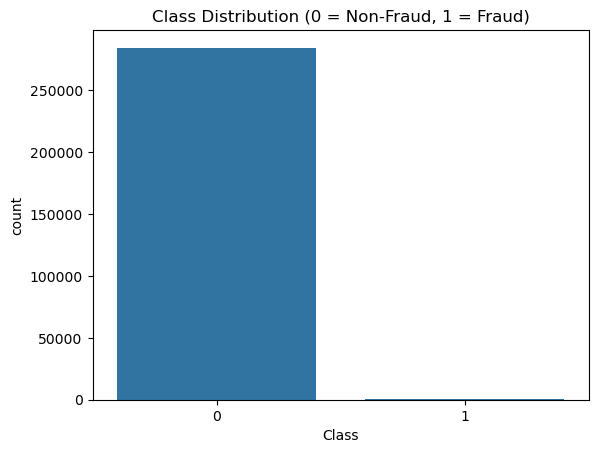

In [4]:
# Check class distribution
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0 = Non-Fraud, 1 = Fraud)')
plt.show()

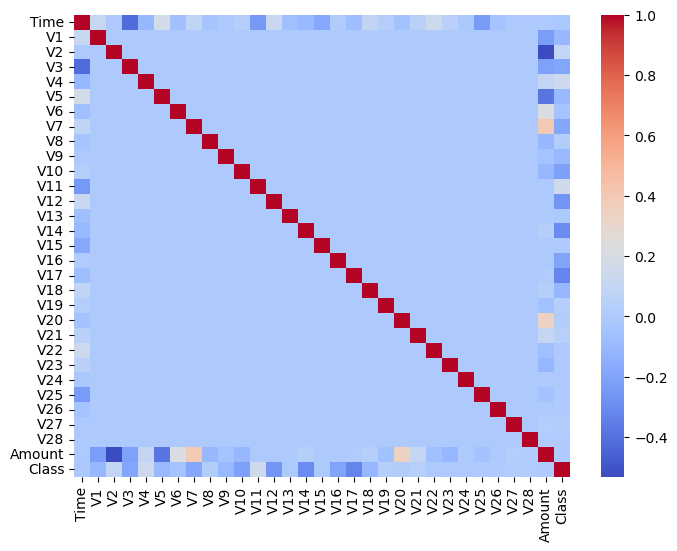

In [7]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.show()


## Data Preprocessing

In [21]:
df.duplicated()
df.drop_duplicates()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [8]:
# Split features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Scale 'Time' and 'Amount'
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [19]:
import joblib

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

## Build Baseline Models
- Logistic Regression
- Random Forest 

In [9]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_res, y_train_res)
y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.84      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



## Hyperparameter Tuning (Random Forest)

In [11]:
from sklearn.model_selection import RandomizedSearchCV
# setting parameters grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [12]:
rf_tuned = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rf_tuned.fit(X_train_res, y_train_res)
print("Best Parameters:", rf_tuned.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 3.7min
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=25.5min
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=12.7min
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 7.6min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=21.5min
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=13.0min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 9.2min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_est

## Evaluate Tuned Model

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9698827600117144


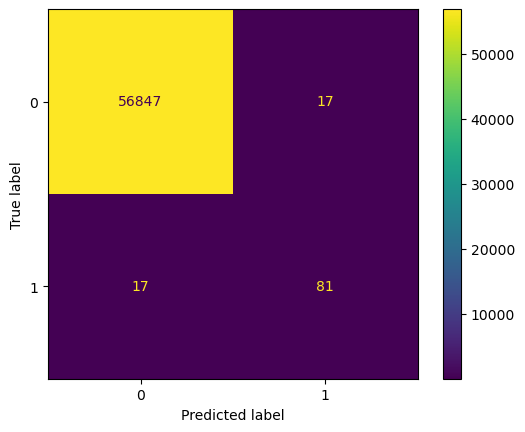

In [13]:
best_rf = rf_tuned.best_estimator_
y_pred_best = best_rf.predict(X_test)
y_proba_best = best_rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_best))

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test)
plt.show()


## ROC & Precision-Recall Curve

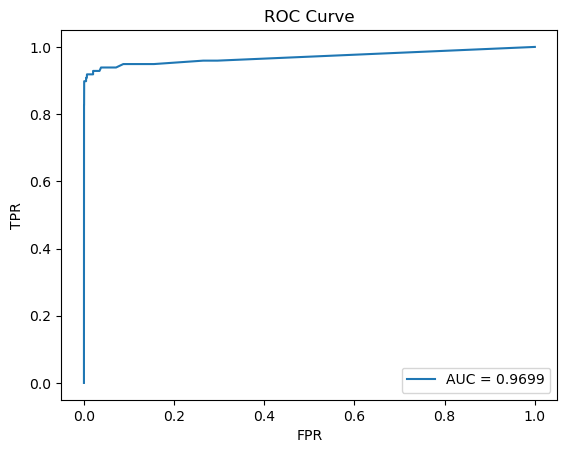

In [14]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()

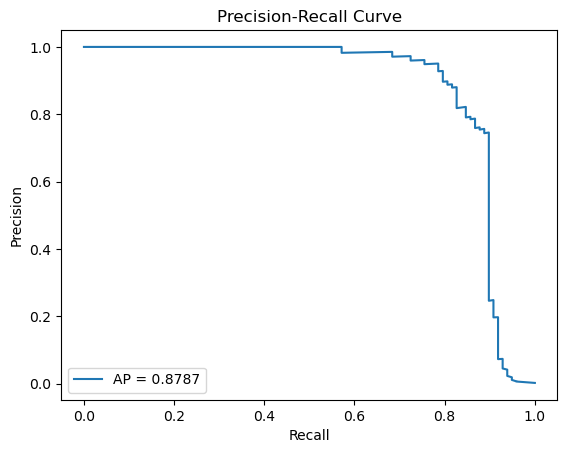

In [15]:

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_best)
avg_precision = average_precision_score(y_test, y_proba_best)
plt.plot(recall, precision, label=f"AP = {avg_precision:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()
